# Visualize the Graphical Structure of Countries by their Amenity Distributions

In [1]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd

# Load NUTS Regions

In [55]:
filepath = "data/nuts_60m.gpkg"

gdf_nuts = gpd.read_file(
    filepath, 
    ignore_fields=['nuts_name', 'population'],
    driver='GPKG')
gdf_nuts = gdf_nuts.rename(
    columns={'cntr_code': 'country', 'name_latn': 'name'})
gdf_nuts['name'] = gdf_nuts['name'].str.title().str[:20]
gdf_nuts = gdf_nuts.set_index("nuts_id")
gdf_nuts.head(2)

,levl_code,country,name,geometry
nuts_id,,,,
AT,0,AT,Österreich,"MULTIPOLYGON (((16.94000 48.61700, 16.95000 48..."
BG,0,BG,Bulgaria,"MULTIPOLYGON (((28.57900 43.73900, 28.53000 43..."


# Load Normalized Amenity Features

In [56]:
filepath = "data/europe-amenity-features.csv.gz"

df = pd.read_csv(filepath, index_col='nuts_id')

# Filter for countries and for rows with no entries
mask = (df.index.str.len() == 2) & (~df.isna().all(axis=1))
df = df[mask]
df.head(2)

,parking,bench,place_of_worship,restaurant,school,parking_space,fuel,waste_basket,cafe,fast_food,...,car_wash,marketplace,bus_station,college,public_building,university,charging_station,bicycle_rental,veterinary,theatre
nuts_id,,,,,,,,,,,,,,,,,,,,,
AL,0.000605,0.00040,0.000323,0.000749,0.000343,0.000018,0.000475,0.000020,0.000630,0.000145,...,0.00010,0.000053,0.000035,0.000005,7.027518e-07,0.000038,0.000001,0.000009,0.000008,0.000013
AT,0.013782,0.00583,0.002673,0.002959,0.000899,0.005506,0.000465,0.001506,0.000657,0.000459,...,0.00018,0.000027,0.000029,0.000011,9.717939e-05,0.000069,0.000245,0.000054,0.000088,0.000053


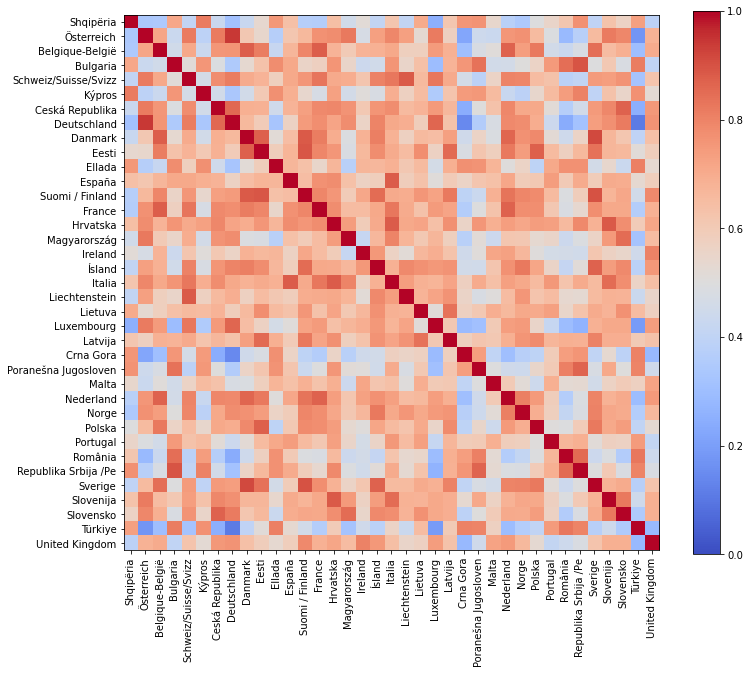

In [57]:
df_tmp = df.applymap(lambda x: np.log10(x * 100_000) if x > 0 else np.nan)
df_tmp = df_tmp.join(gdf_nuts['name']).set_index('name')
df_corr = df_tmp.T.corr()

plt.figure(figsize=(12, 10))
plt.imshow(df_corr, cmap='coolwarm', vmin=0, vmax=1)
plt.colorbar()
locs = range(len(df_corr.columns))
plt.xticks(locs, df_corr.columns, rotation=90, fontsize=10)
plt.yticks(locs, df_corr.columns, fontsize=10)
plt.grid(False);

# Cluster Countries by their Amenity

In [58]:
from sklearn import cluster, covariance, manifold

In [82]:
df_tmp = df.applymap(lambda x: np.log10(x * 100_000) if x > 0 else -2)
df_tmp = df_tmp.join(gdf_nuts['name']).set_index('name').T

In [83]:
X = df_tmp.values
X -= X.mean(axis=0)
X /= X.std(axis=0)

edge_model = covariance.GraphicalLassoCV()
edge_model.fit(X)

/home/nikolai/anaconda3/envs/gis/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:266: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.768e-04
  % (max_iter, d_gap), ConvergenceWarning)


GraphicalLassoCV()

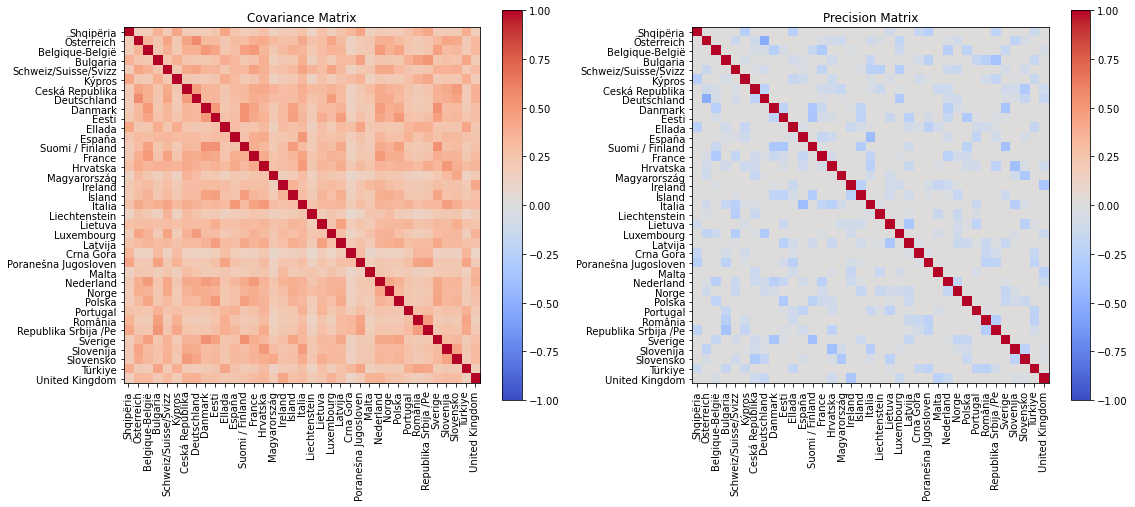

In [84]:
locs = range(len(df_tmp.columns))
labels = df_tmp.columns

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(edge_model.covariance_, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Covariance Matrix')
plt.xticks(locs, df_corr.columns, rotation=90, fontsize=10)
plt.yticks(locs, df_corr.columns, fontsize=10)
plt.grid(False)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(edge_model.precision_, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Precision Matrix')
plt.xticks(locs, df_corr.columns, rotation=90, fontsize=10)
plt.yticks(locs, df_corr.columns, fontsize=10)
plt.grid(False)
plt.colorbar()
plt.tight_layout();

In [86]:
names = df_tmp.columns

centers, labels = cluster.affinity_propagation(
    edge_model.covariance_, random_state=1000)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Österreich, Deutschland, Luxembourg, Nederland, Norge
Cluster 2: Belgique-België, Danmark, Eesti, Suomi / Finland, Ísland, Latvija, Polska, Sverige
Cluster 3: Schweiz/Suisse/Svizz, España, France, Hrvatska, Italia, Portugal, Slovenija
Cluster 4: Liechtenstein
Cluster 5: Shqipëria, Bulgaria, Kýpros, Ellada, Crna Gora, Poranešna Jugosloven, România, Republika Srbija /Ре, Türkiye
Cluster 6: Ceská Republika, Magyarország, Lietuva, Slovensko
Cluster 7: Ireland, Malta, United Kingdom


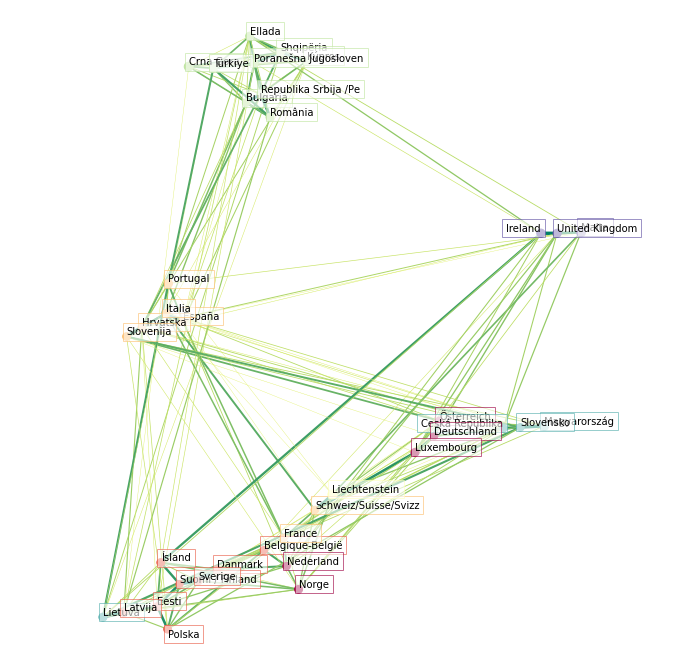

In [88]:
from scripts import draw_utils

tsne = manifold.TSNE(n_components=2, perplexity=2, n_iter=1000)
embedding = tsne.fit_transform(X.T)

centers, labels = cluster.affinity_propagation(
    edge_model.covariance_, random_state=1000)

plt.figure(figsize=(12, 12))
draw_utils.visualize_graph(embedding, edge_model.precision_, names, labels)